## Задача 1

## Шаг 1. Загрузка данных

Импортируем все необходимые библиотеки для дальнейшей работы в отдельной ячейке

In [1]:
!pip install phik -q
!pip install -U scikit-learn -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, roc_auc_score

Загружаем данные и проверяем на соответствие описанной информации

In [3]:
train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

In [4]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [5]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [6]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Описанные столбцы в датасетах соответствуют загруженным данным, теперь рассмотрим общую информацию

In [7]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


В этом датасете 4000 строк и в столбцах **dept** и **level** есть пропуски. Все столбцы имеют корректный тип данных

In [8]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Здесь мы имеем 2000 строк и пропуски в аналогичных столбцах. Все столбцы имеют корректный тип данных

In [9]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Здесь так же 2000 строк, пропусков нет. Все столбцы имеют корректный тип данных

На этом шаге мы загрузили данные и проверили их соответствие описанной информации. Узнали, в каких столбцах есть пропуски и убедились в корректности типов данных. Также, стоить отметить, что все столбцы имеют корректные названия

## Шаг 2. Предобработка данных

Как было отмечено в предыдущем пункте, все столбцы имеют корректное название. Поэтому перейдем к поиску явных и неявных дубликатов

Неявные дубли могут находиться только лишь в категориальных столбцах, поэтому рассмотрим все уникальные значения таких столбцов

In [10]:
cat_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

for col in cat_columns:
    print(train_job_satisfaction_rate[col].unique())

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
['no' 'yes']
['no' 'yes']


Неявные дубликаты не обнаружены, поэтому проверим явные

In [11]:
train_job_satisfaction_rate.duplicated().sum()

0

Явных дубликатов тоже нет. Остались пропуски, но они будут заполнены на этапе создания пайплайна внутри него

Проверим тестовую выборку

In [12]:
test_features.duplicated().sum()

0

In [13]:
test_target_job_satisfaction_rate.duplicated().sum()

0

In [14]:
cat_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

for col in cat_columns:
    print(test_features[col].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


В тестовой выборке тоже все в порядке с дубликатами. Однако мы увидели пустующие строки. Заменим их на nan

In [15]:
test_features['dept'] = test_features['dept'].replace(' ', np.nan)
test_features['workload'] = test_features['workload'].replace(' ', np.nan)

На этом этапе мы проверили данные на наличие явных и неявных дубликатов. Так же, заменили пустующие строки на nan в тестовой выборке

## Шаг 3. Исследовательский анализ данных

Проведем исследовательский анализ данных всех признаков в датасетах

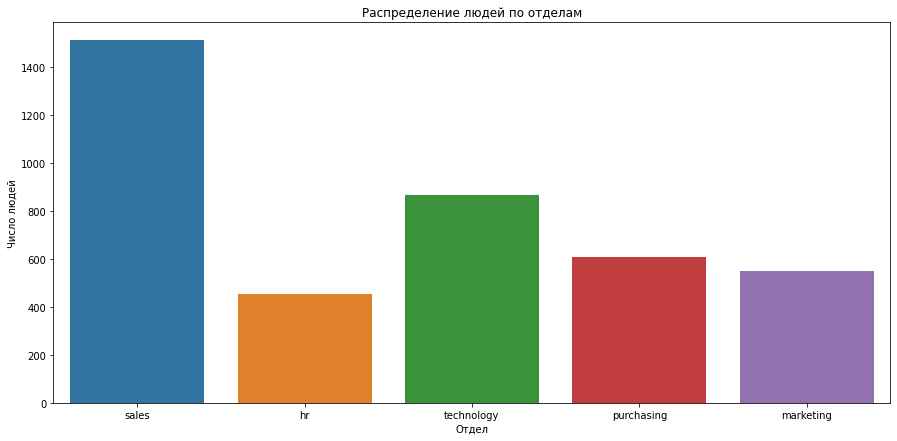

In [16]:
plt.figure(figsize=(15, 7))
sns.countplot(x='dept', data=train_job_satisfaction_rate)
plt.xlabel('Отдел')
plt.ylabel('Число людей')
plt.title('Распределение людей по отделам')
plt.show()

Можем заметить на графике выше, что больше всего людей работает в отделе sales, в остальных отделах людей примерно поровну

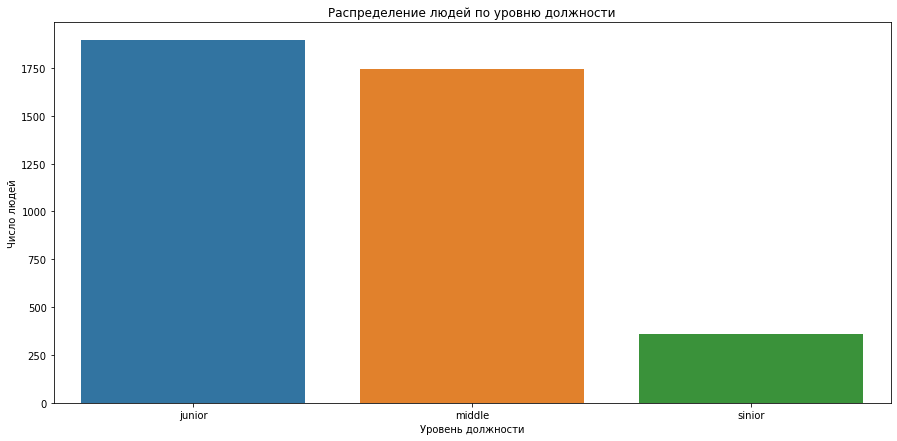

In [17]:
plt.figure(figsize=(15, 7))
sns.countplot(x='level', data=train_job_satisfaction_rate)
plt.xlabel('Уровень должности')
plt.ylabel('Число людей')
plt.title('Распределение людей по уровню должности')
plt.show()

Больше всего людей в компании - junior специалисты. Чуть меньше людей на middle позиции и совсем мало на sinior

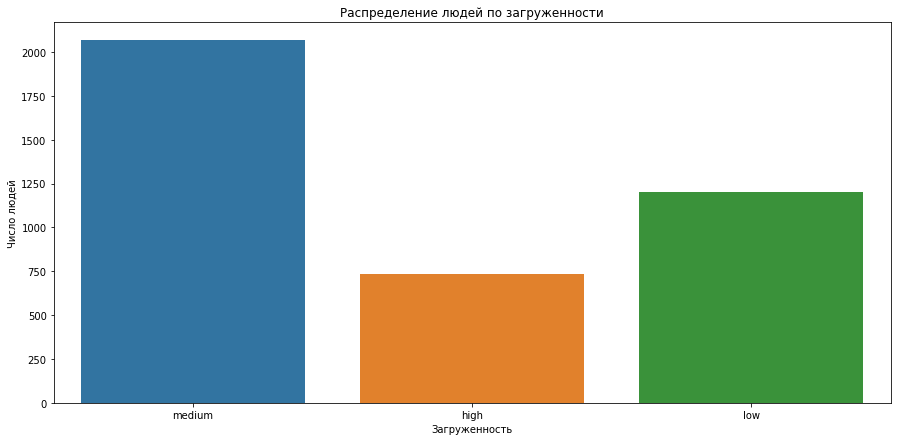

In [18]:
plt.figure(figsize=(15, 7))
sns.countplot(x='workload', data=train_job_satisfaction_rate)
plt.xlabel('Загруженность')
plt.ylabel('Число людей')
plt.title('Распределение людей по загруженности')
plt.show()

В основном сотрудники имеют умеренную нагрузку

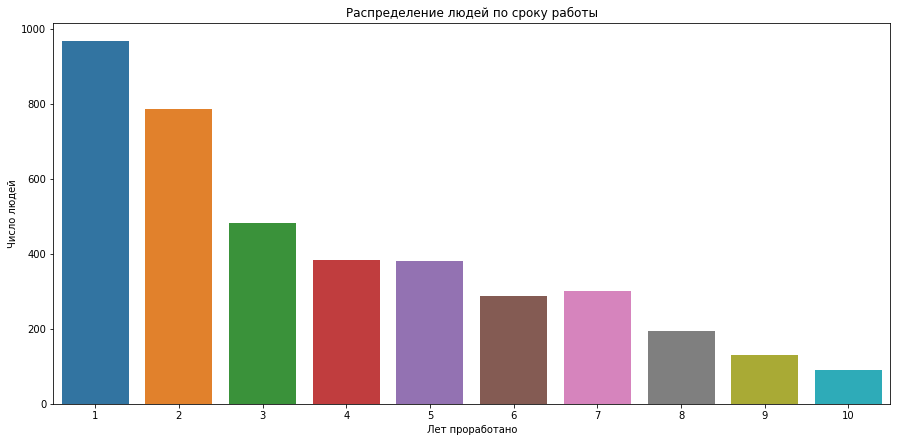

In [19]:
plt.figure(figsize=(15, 7))
sns.countplot(x='employment_years', data=train_job_satisfaction_rate)
plt.xlabel('Лет проработано')
plt.ylabel('Число людей')
plt.title('Распределение людей по сроку работы')
plt.show()

Очень много сотрудников, которые недавно в компании и совсем мало со стажем работы в компании от 8 лет и более. Логичное распределение

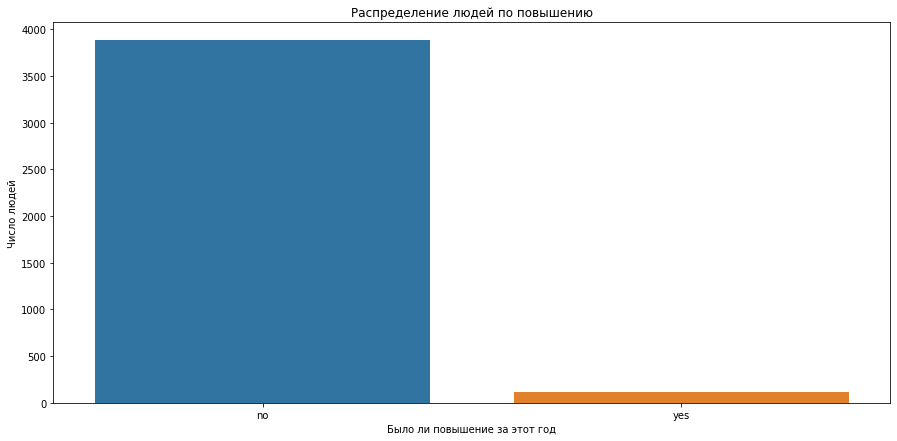

In [20]:
plt.figure(figsize=(15, 7))
sns.countplot(x='last_year_promo', data=train_job_satisfaction_rate)
plt.xlabel('Было ли повышение за этот год')
plt.ylabel('Число людей')
plt.title('Распределение людей по повышению')
plt.show()

В основном сотрудники не были повышены в должности в прошлом году

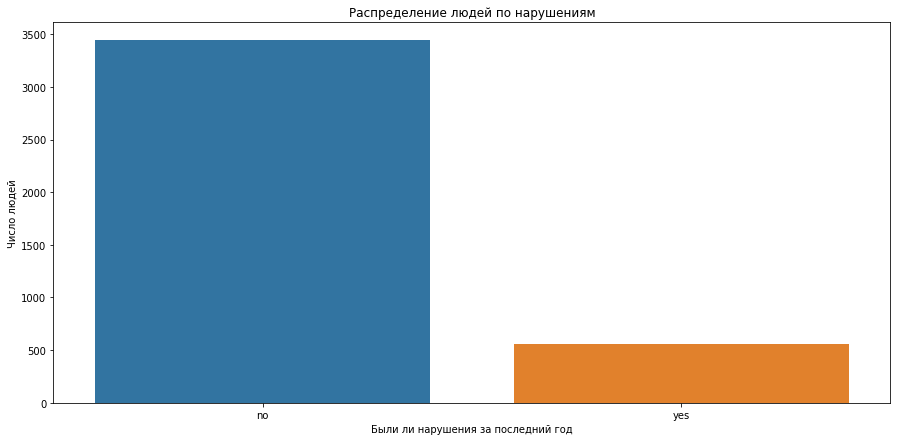

In [21]:
plt.figure(figsize=(15, 7))
sns.countplot(x='last_year_violations', data=train_job_satisfaction_rate)
plt.xlabel('Были ли нарушения за последний год')
plt.ylabel('Число людей')
plt.title('Распределение людей по нарушениям')
plt.show()

Около 700 сотрудников нарушили правила компании. Но в основном больше людей, которые их не нарушали 

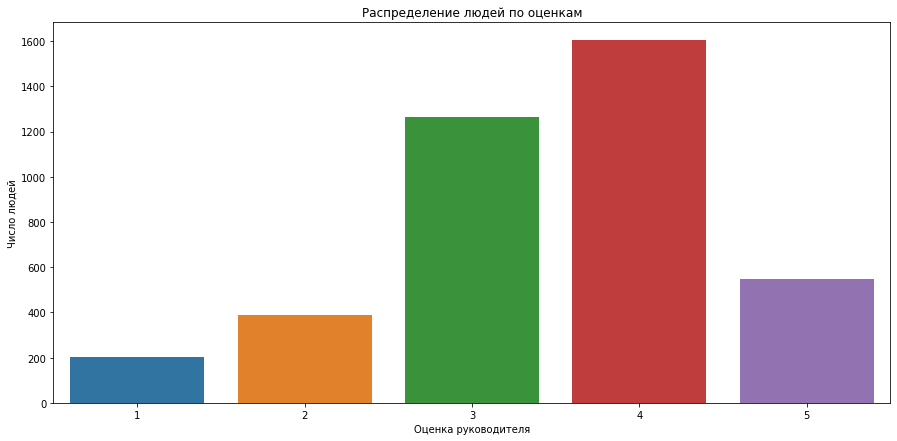

In [22]:
plt.figure(figsize=(15, 7))
sns.countplot(x='supervisor_evaluation', data=train_job_satisfaction_rate)
plt.xlabel('Оценка руководителя')
plt.ylabel('Число людей')
plt.title('Распределение людей по оценкам')
plt.show()

Оценки распределены по 5-бальной шкале. В основном все получают 3 и 4 балла

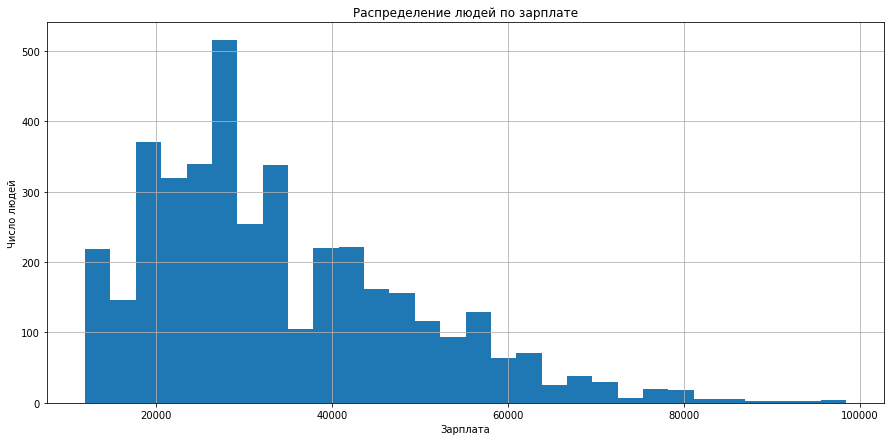

In [23]:
train_job_satisfaction_rate['salary'].hist(figsize=(15, 7), bins=30)
plt.xlabel('Зарплата')
plt.ylabel('Число людей')
plt.title('Распределение людей по зарплате')
plt.show()

Аномальных значений не обнаружено. Распределение имеет нормальную форму со смещением влево, есть пик

In [24]:
train_job_satisfaction_rate['salary'].describe()

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

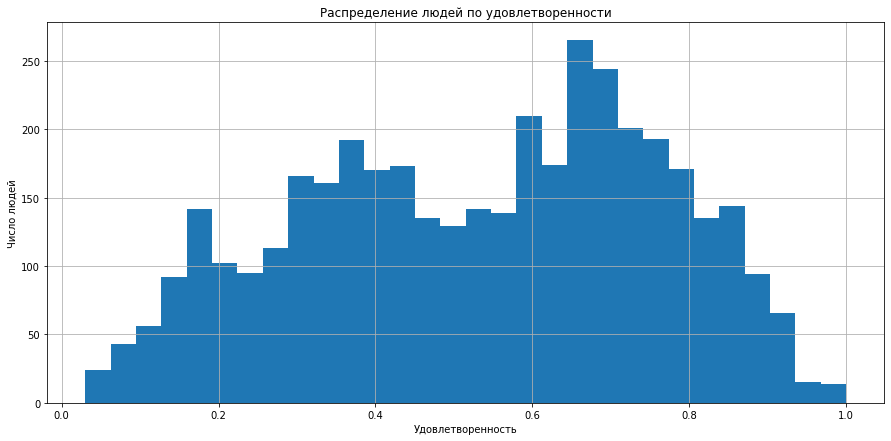

In [25]:
train_job_satisfaction_rate['job_satisfaction_rate'].hist(figsize=(15, 7), bins=30)
plt.xlabel('Удовлетворенность')
plt.ylabel('Число людей')
plt.title('Распределение людей по удовлетворенности')
plt.show()

Удовлетворенность распределена нормальным образом с пиком ближе к правой стороне. Аномалий так же нет, все значения лежат в пределе от 0 до 1

На этом этапе мы провели исследовательский анализ данных всех признаков в тренировочной выборке 

Проведем аналогичный анализ для тестовой выборки

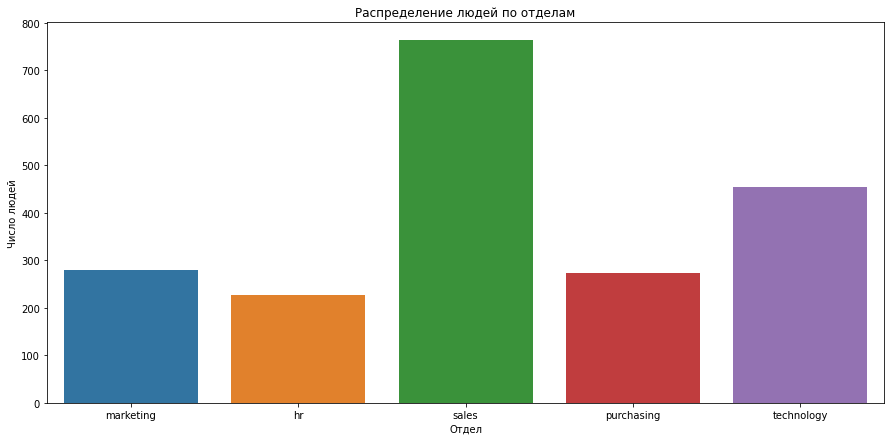

In [26]:
plt.figure(figsize=(15, 7))
sns.countplot(x='dept', data=test_features)
plt.xlabel('Отдел')
plt.ylabel('Число людей')
plt.title('Распределение людей по отделам')
plt.show()

Здесь аналогичная ситуация с тренировочной выборкой: больше всего сотрудников в отделе продаж и технологий. Остальных примерно поровну

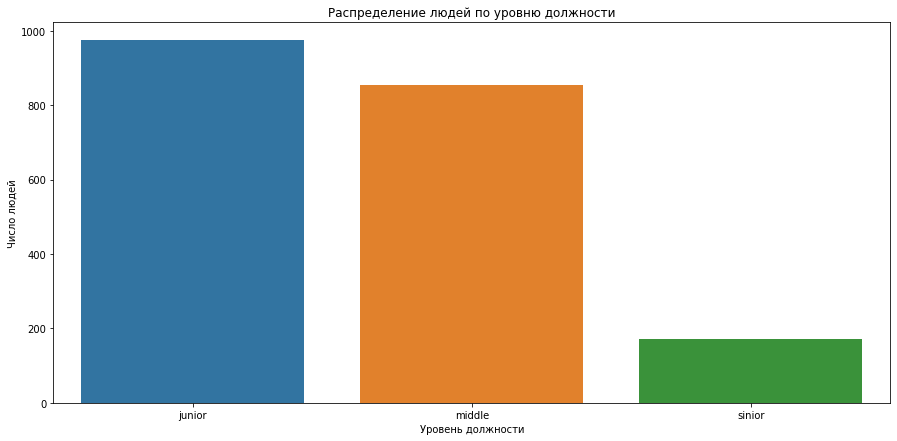

In [27]:
plt.figure(figsize=(15, 7))
sns.countplot(x='level', data=test_features)
plt.xlabel('Уровень должности')
plt.ylabel('Число людей')
plt.title('Распределение людей по уровню должности')
plt.show()

Здесь то же самое: джун и миддл специалистов больше, чем сеньоров

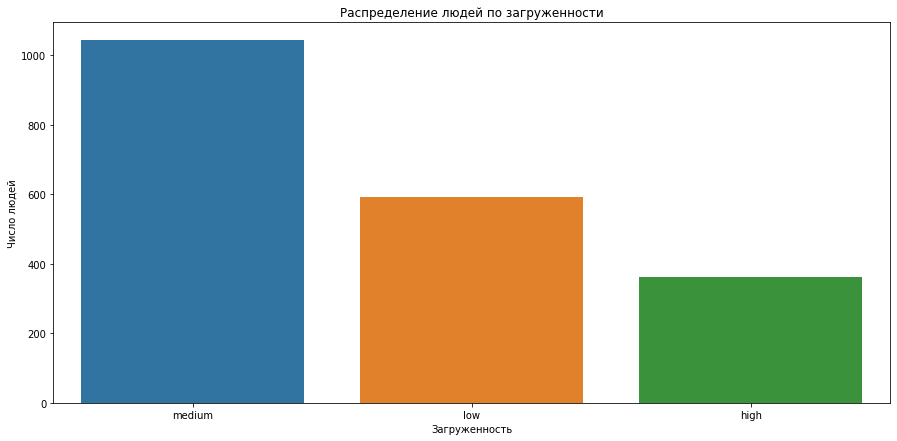

In [28]:
plt.figure(figsize=(15, 7))
sns.countplot(x='workload', data=test_features)
plt.xlabel('Загруженность')
plt.ylabel('Число людей')
plt.title('Распределение людей по загруженности')
plt.show()

Больше всего сотрудников с умеренной нагрузкой, далее идет низкая и высокая нагрузка

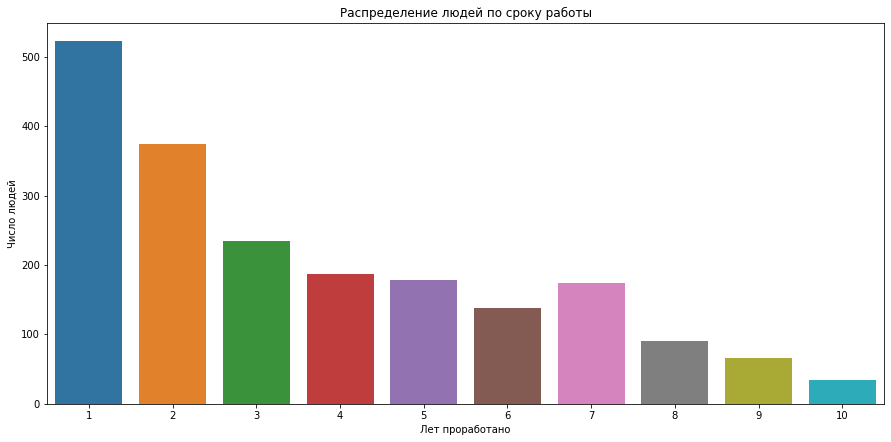

In [29]:
plt.figure(figsize=(15, 7))
sns.countplot(x='employment_years', data=test_features)
plt.xlabel('Лет проработано')
plt.ylabel('Число людей')
plt.title('Распределение людей по сроку работы')
plt.show()

Распределение такое же как у тренировочной выборки

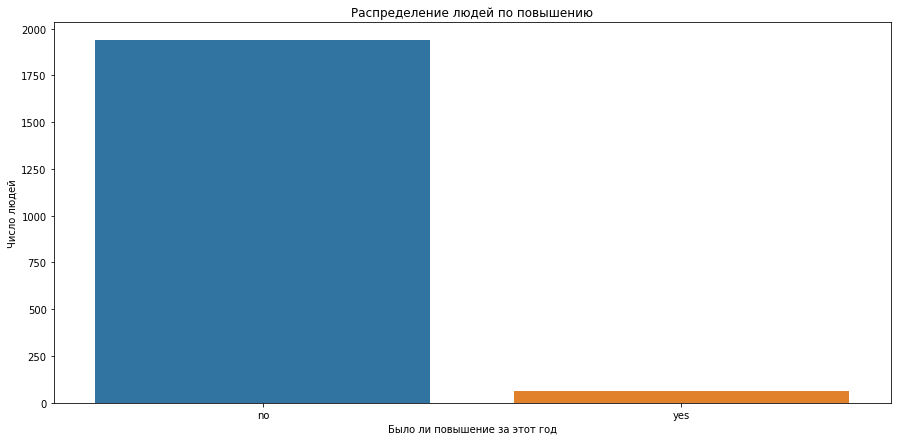

In [30]:
plt.figure(figsize=(15, 7))
sns.countplot(x='last_year_promo', data=test_features)
plt.xlabel('Было ли повышение за этот год')
plt.ylabel('Число людей')
plt.title('Распределение людей по повышению')
plt.show()

Аналогично с тренировочной выборкой

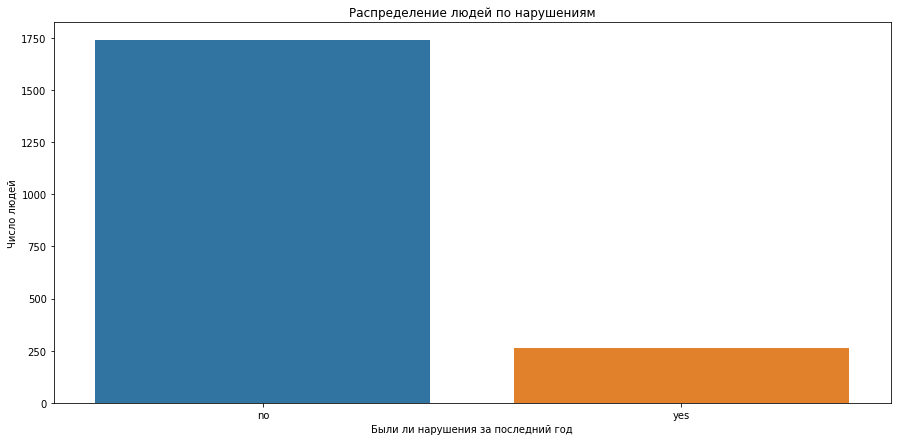

In [31]:
plt.figure(figsize=(15, 7))
sns.countplot(x='last_year_violations', data=test_features)
plt.xlabel('Были ли нарушения за последний год')
plt.ylabel('Число людей')
plt.title('Распределение людей по нарушениям')
plt.show()

Распределение схоже с распределением тренировочной выборки

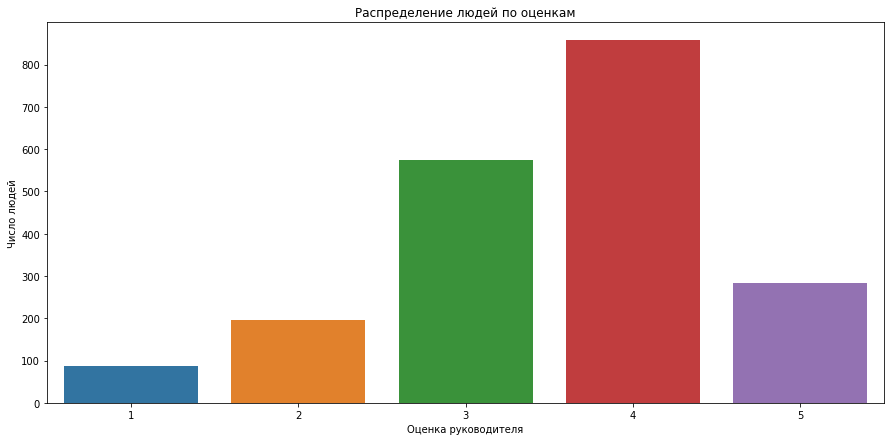

In [32]:
plt.figure(figsize=(15, 7))
sns.countplot(x='supervisor_evaluation', data=test_features)
plt.xlabel('Оценка руководителя')
plt.ylabel('Число людей')
plt.title('Распределение людей по оценкам')
plt.show()

Больше всего оценок 3 и 4. Аналогичная ситуация с тренировочной выборкой

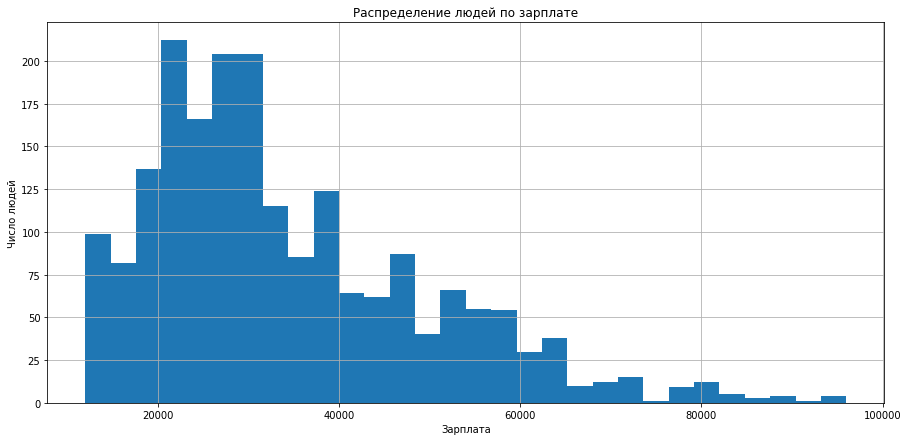

In [33]:
test_features['salary'].hist(figsize=(15, 7), bins=30)
plt.xlabel('Зарплата')
plt.ylabel('Число людей')
plt.title('Распределение людей по зарплате')
plt.show()

Зарплаты в тренировочной выборке распределены нормальным образом со смещением влево. Явно виден пик, нет аномалий

## Шаг 4. Подготовка данных

Подготовим пайплайн для обучения моделей. Для начала рассчитаем коэффициенты корреляции и проверим на мультиколлинеарность

In [34]:
interval_cols = ['salary', 'job_satisfaction_rate']

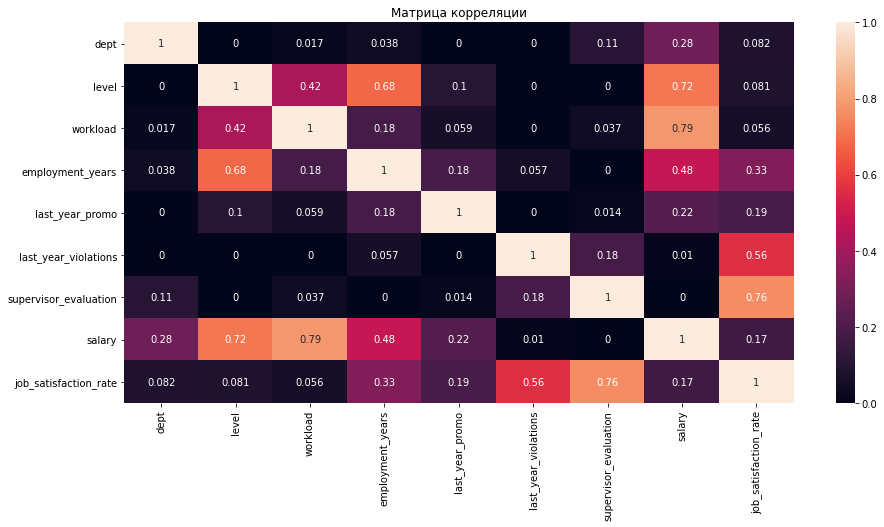

In [35]:
phik_corr = train_job_satisfaction_rate.drop(['id'], axis=1).phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(15, 7))
sns.heatmap(phik_corr, annot=True)
plt.title('Матрица корреляции')
plt.show()

Признаки считаются мультиколлинеарными, если коэффициент корреляции составляет более 0.9. Таких признаков в датасете не обнаружено

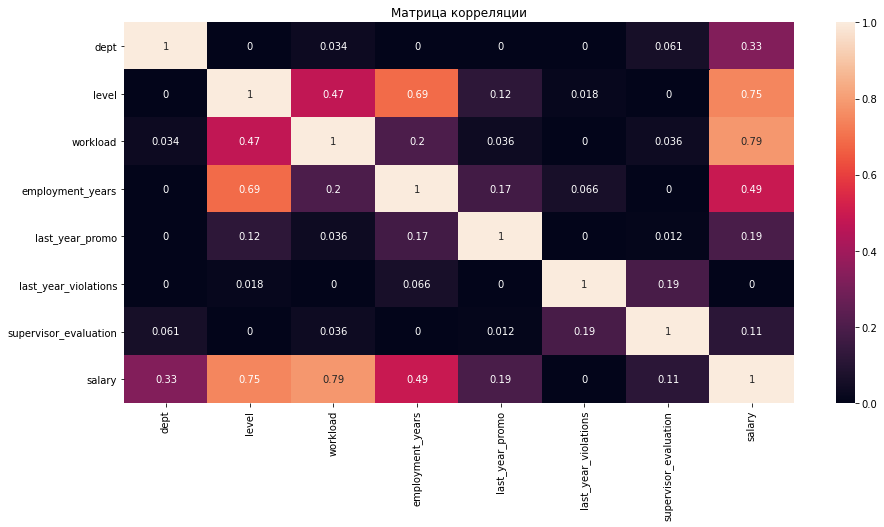

In [36]:
phik_corr = test_features.drop(['id'], axis=1).phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(15, 7))
sns.heatmap(phik_corr, annot=True)
plt.title('Матрица корреляции')
plt.show()

Мультиколлинеарности не обнаружено

Создадим пайплайн и будем использовать **ColumnTransformer** в качестве подготовки данных

In [37]:
X_train = train_job_satisfaction_rate.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']
RANDOM_STATE = 42

Выберем ранговые, номинальные и количественные категории данных

In [38]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

ord_columns = ['level', 'workload']

num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

Создадим пайпы для всех столбцов и сделаем препроцессор данных

In [39]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [40]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[['junior', 'middle', 'sinior'],
                                       ['low', 'medium', 'high']], handle_unknown='use_encoded_value', unknown_value=np.nan)
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

Создадим словари для всех моделей

In [41]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__min_samples_leaf': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    #словарь для модели GradientBoostingRegressor()
    {
        'models':[GradientBoostingRegressor()],
        'models__n_estimators': [100, 150, 200],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__max_depth': range(2, 5),
        'models__min_samples_leaf': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Модель будем оценивать по метрике SMAPE, напишем функцию для ее реализации, используя **make_scorer**

In [42]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / denominator) * 100

smape_scorer = make_scorer(smape, greater_is_better=False)

На этом этапе мы создали финальный пайплайн, включающий в себя предобработку данных (заполнение пропусков). В него вошли 3 модели с перебором гиперпараметров и метрикой SMAPE

## Шаг 5. Обучение моделей

Будем обучать модели, используя **RandomizedSearchCV**

In [43]:
random_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                                               'passthrough']},
                                        {'models': [GradientBoostingRegressor()],
                                         'models__learning_rate': [0.01, 0.05,
                                                                   0.1],
                                         'models__max_depth': range(2, 5),
                                         'models__min_samples_leaf': range(2, 5),
                                         'models__n_estimators': [100, 150,
                                                                  200],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [44]:
print("SMAPE:", -random_search.best_score_) 
print('Лучшие параметры:', random_search.best_params_)

SMAPE: 12.25086610041772
Лучшие параметры: {'preprocessor__num': 'passthrough', 'models__n_estimators': 150, 'models__min_samples_leaf': 2, 'models__max_depth': 4, 'models__learning_rate': 0.1, 'models': GradientBoostingRegressor()}


На тренировочной выборке SMAPE показала хороший результат, он проходит по критерию < 15. Но у нас есть тестовая выборка, разобьем ее на входные и целевой признаки и посмотрим как SMAPE показывает себя на тестовых данных

In [45]:
test = test_features.merge(test_target_job_satisfaction_rate, on='id') #объединили и снова разделили, потому что изначально целевой признак не стыкуется по id
X_test = test.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = test['job_satisfaction_rate']
y_pred_test = random_search.predict(X_test)
test_smape = smape(y_test, y_pred_test)
print("SMAPE:", test_smape)

SMAPE: 11.67146994935145


Модель снова показала отличный результат со SMAPE < 15

## Шаг 6. Оформление выводов

В данной задаче мы выполнили предобработку данных и обучение трех моделей в пайплайне. В качестве моделей мы использовали **DecisionTreeRegressor**, **LinearRegression** и **GradientBoostingRegressor**

Лучшей себя показала последняя модель с метрикой SMAPE на тестовой выборке 11.68. Это связано с тем, что градиентный бустинг строит последовательность деревьев, минимизируя ошибку через градиентный спуск. То есть каждая следующая модель исправляет ошибки предыдущей

## Задача 2

## Шаг 1. Загрузка данных

Загрузим данные для новой задачи

In [46]:
train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

In [47]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [48]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Данные соответсвуют описанным, посмотрим на них через метод info

In [49]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [50]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Типы данных во всех столбцах корректны, а так же нет проблем с пропусками. Названия столбцов так же в полном порядке

Перейдем к предобработке

## Шаг 2. Предобработка данных

Как было отмечено в предыдущем пункте, все столбцы имеют корректное название, не имеют пропусков и корректный тип данных. Поэтому перейдем к поиску явных и неявных дубликатов

Неявные дубли могут находиться только лишь в категориальных столбцах, поэтому рассмотрим все уникальные значения таких столбцов

In [51]:
cat_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']

for col in cat_columns:
    print(train_quit[col].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']
['no' 'yes']


Неявных дубликатов не обнаружено, рассмотрим явные дубли

In [52]:
train_quit.duplicated().sum()

0

Явных дубликатов тоже нет, а выборка test_feauters уже была рассмотрена в прошлой задаче, поэтому все пункты с предобработкой пропусков будут выполнены аналогично в пайплайне. Рассмотрим неявные дубликаты в целевом признаке

In [53]:
test_target_quit['quit'].unique()

array(['yes', 'no'], dtype=object)

Все в порядке

На данном этапе мы проверили данные на явные и неявные дубликаты

## Шаг 3. Исследовательский анализ данных

Проведем исследовательский анализ данных всех параметров из датасета 

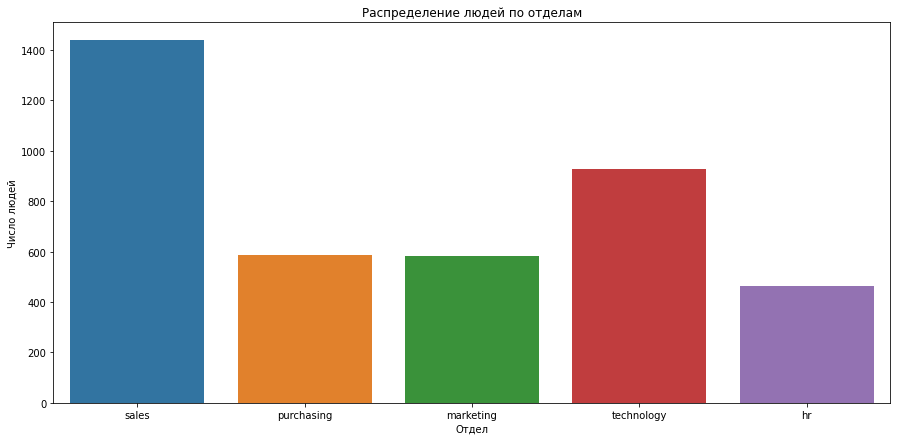

In [54]:
plt.figure(figsize=(15, 7))
sns.countplot(x='dept', data=train_quit)
plt.xlabel('Отдел')
plt.ylabel('Число людей')
plt.title('Распределение людей по отделам')
plt.show()

В новой выборке преобладают сотрудники в отделе продаж и отделе технологий. На остальные отделы приходится приблизительно одинаковое количество сотрудников

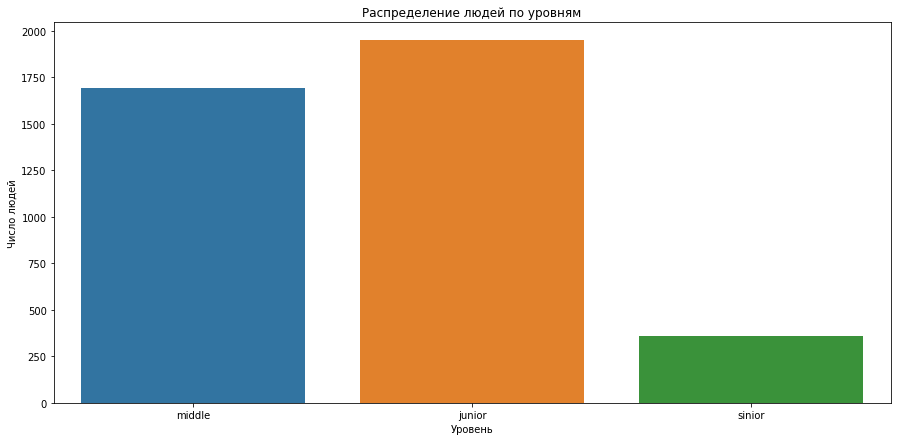

In [84]:
plt.figure(figsize=(15, 7))
sns.countplot(x='level', data=train_quit)
plt.xlabel('Уровень')
plt.ylabel('Число людей')
plt.title('Распределение людей по уровням')
plt.show()

Как и ожидалось - больше всего джуниор и миддл специалистов. Сеньор специалистов около 250 человек

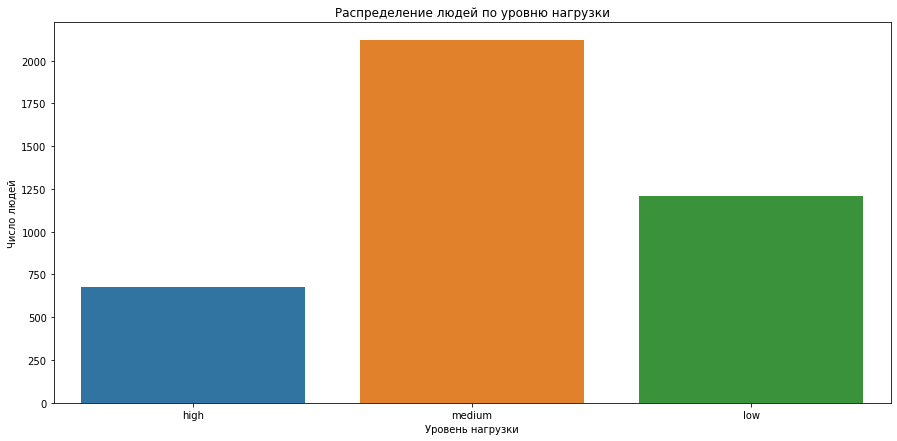

In [85]:
plt.figure(figsize=(15, 7))
sns.countplot(x='workload', data=train_quit)
plt.xlabel('Уровень нагрузки')
plt.ylabel('Число людей')
plt.title('Распределение людей по уровню нагрузки')
plt.show()

Примерно 2000 сотрудников имеют умеренный уровень загруженности. 1250 - низкий и остальные - высокий

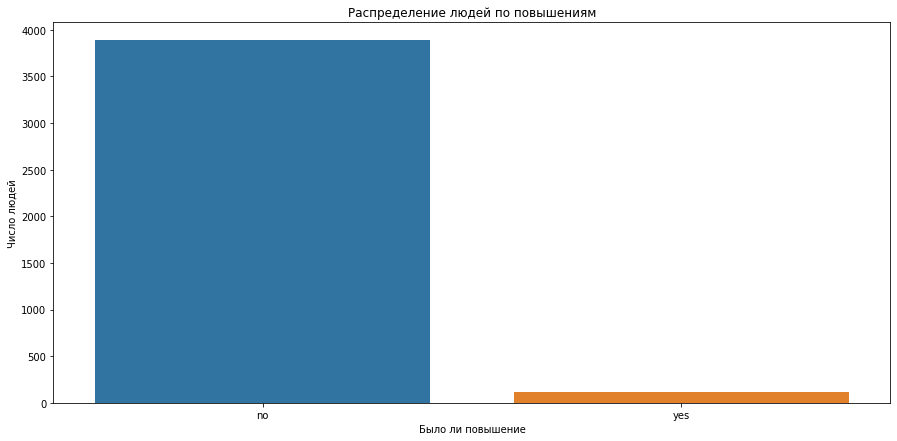

In [86]:
plt.figure(figsize=(15, 7))
sns.countplot(x='last_year_promo', data=train_quit)
plt.xlabel('Было ли повышение')
plt.ylabel('Число людей')
plt.title('Распределение людей по повышениям')
plt.show()

Почти все сотрудники не были повышены в должности за последний год. Совсем малая часть приходится на тех, кто был повышен

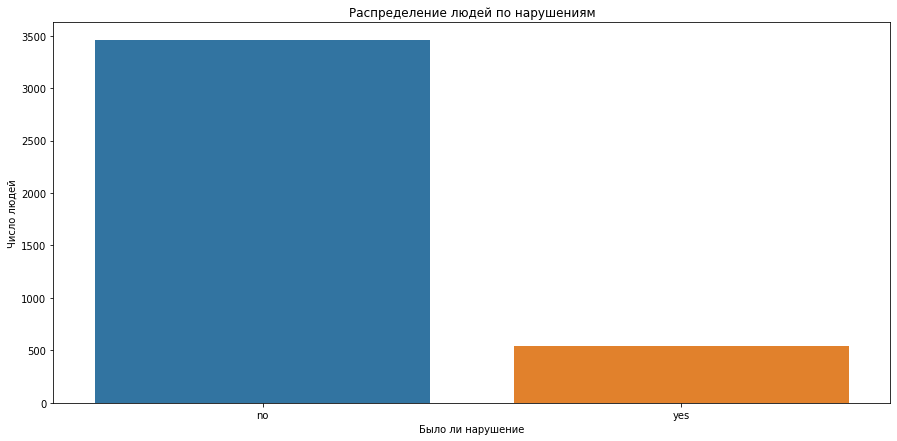

In [87]:
plt.figure(figsize=(15, 7))
sns.countplot(x='last_year_violations', data=train_quit)
plt.xlabel('Было ли нарушение')
plt.ylabel('Число людей')
plt.title('Распределение людей по нарушениям')
plt.show()

Более 3000 сотрудников не нарушали правил за последний год

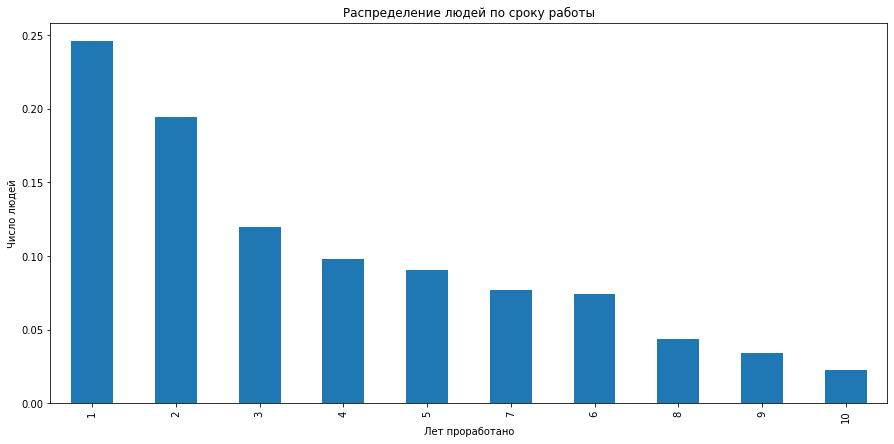

In [59]:
plt.figure(figsize=(15, 7))
train_quit['employment_years'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Лет проработано')
plt.ylabel('Число людей')
plt.title('Распределение людей по сроку работы')
plt.show()

Распределение имеет такой же вид как и в предыдущей задаче

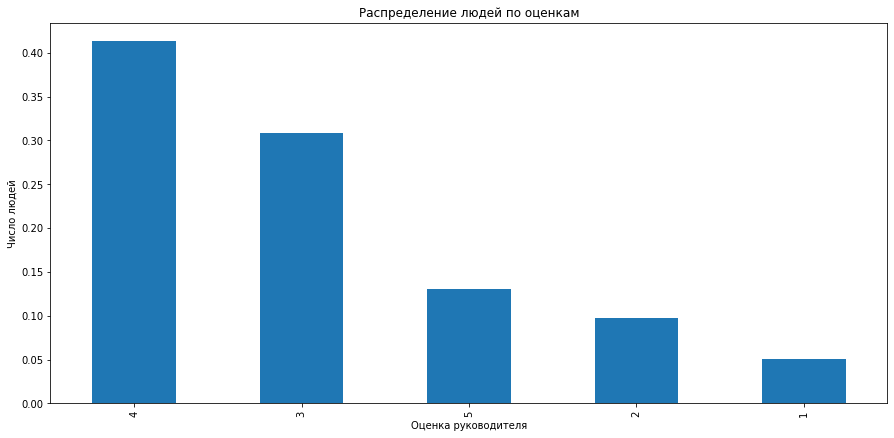

In [60]:
plt.figure(figsize=(15, 7))
train_quit['supervisor_evaluation'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Оценка руководителя')
plt.ylabel('Число людей')
plt.title('Распределение людей по оценкам')
plt.show()

Здесь аналогичная ситуация

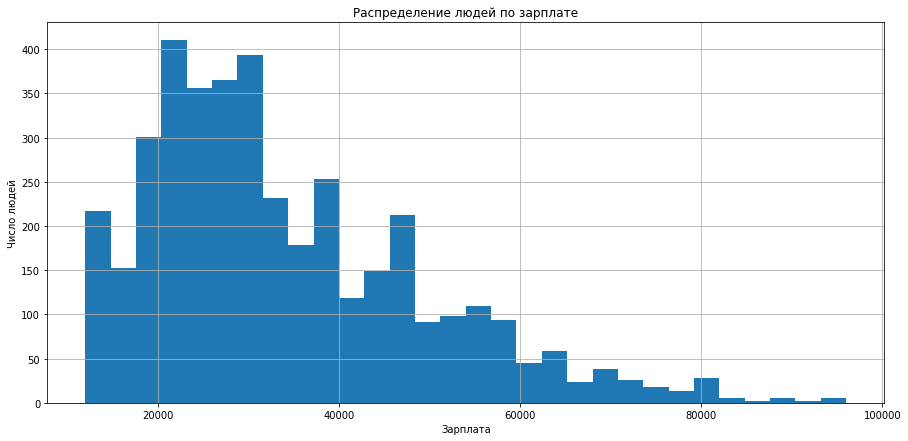

In [61]:
train_quit['salary'].hist(figsize=(15, 7), bins=30)
plt.xlabel('Зарплата')
plt.ylabel('Число людей')
plt.title('Распределение людей по зарплате')
plt.show()

Зарплата в этой тренировочной выборке имеет нормальное распределение со смещением влево, явно виден пик. Аномальных значений не обнаружено

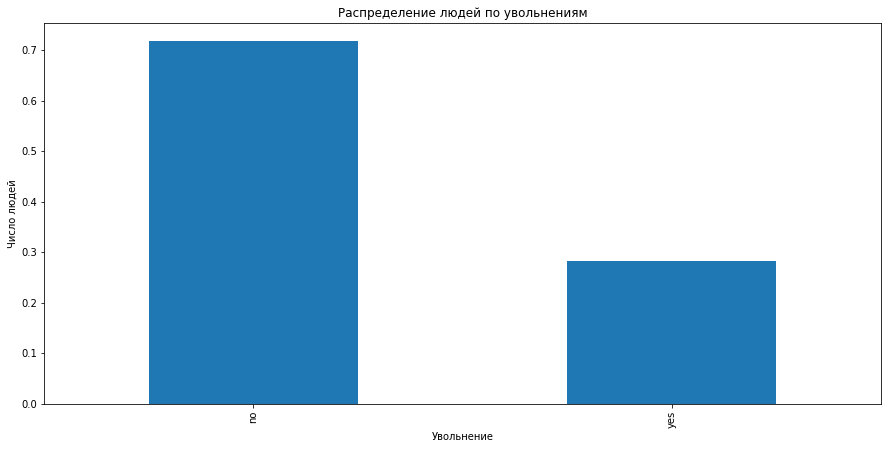

In [62]:
plt.figure(figsize=(15, 7))
train_quit['quit'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Увольнение')
plt.ylabel('Число людей')
plt.title('Распределение людей по увольнениям')
plt.show()

Можем заметить, что большинство людей не уволилось из компании. Однако около 1250 человек все же приняли это решение 

Теперь составим портрет уволившегося сотрудника. Для начала рассмотрим в каком отделе произошло больше всего увольнений и какой был уровень загруженности у уволившегося сотрудника

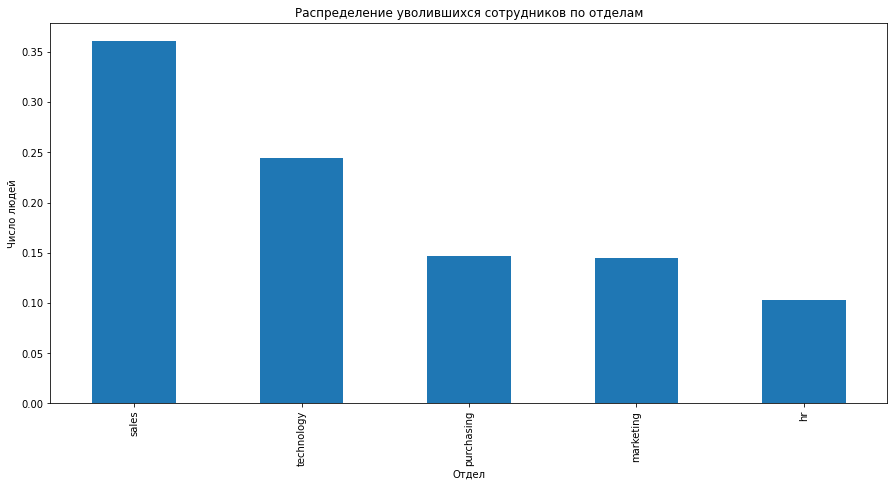

In [63]:
plt.figure(figsize=(15, 7))
train_quit[train_quit['quit'] == 'yes']['dept'].value_counts(normalize=True).plot(kind='bar')
plt.title('Распределение уволившихся сотрудников по отделам')
plt.xlabel('Отдел')
plt.ylabel('Число людей')
plt.show()

Больше всего уволившихся сотрудников приходится на отдел продаж и технологий. Меньше всего уволившихся сотрудников в отделе hr

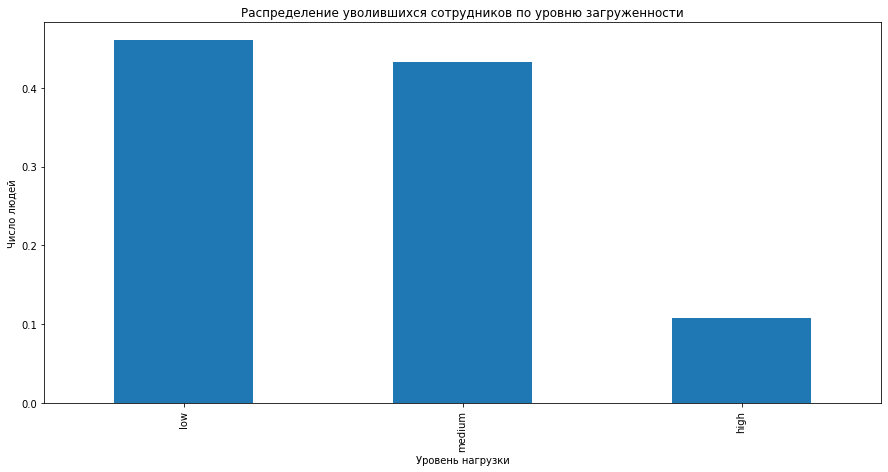

In [64]:
plt.figure(figsize=(15, 7))
train_quit[train_quit['quit'] == 'yes']['workload'].value_counts(normalize=True).plot(kind='bar')
plt.title('Распределение уволившихся сотрудников по уровню загруженности')
plt.xlabel('Уровень нагрузки')
plt.ylabel('Число людей')
plt.show()

На удивление больше всего сотрудников, которые уволились, имели низкий уровень и средний уровень загруженности. Совсем мало сотрудников уволилось из-за высокой нагрузки

Теперь сравним заработные платы уволившихся сотрудников с неуволившимися

In [65]:
train_quit[train_quit['quit'] == 'yes']['salary'].describe()

count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64

In [66]:
train_quit[train_quit['quit'] == 'no']['salary'].describe()

count     2872.000000
mean     37702.228412
std      15218.977339
min      12000.000000
25%      25200.000000
50%      34800.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64

Можем заметить, что средняя зарплата уволившихся сотрудников была меньше в среднем, чем у других. Возможно, это как-то связанно  с уровнем занятости сотрудников

In [67]:
full_data = test_target_quit.merge(test_target_job_satisfaction_rate, on='id')
full_data

,id,quit,job_satisfaction_rate
0,999029,yes,0.35
1,372846,no,0.21
2,726767,no,0.73
3,490105,no,0.62
4,416898,yes,0.57
...,...,...,...
1995,836109,yes,0.61
1996,180999,yes,0.60
1997,746018,no,0.70
1998,247658,no,0.67


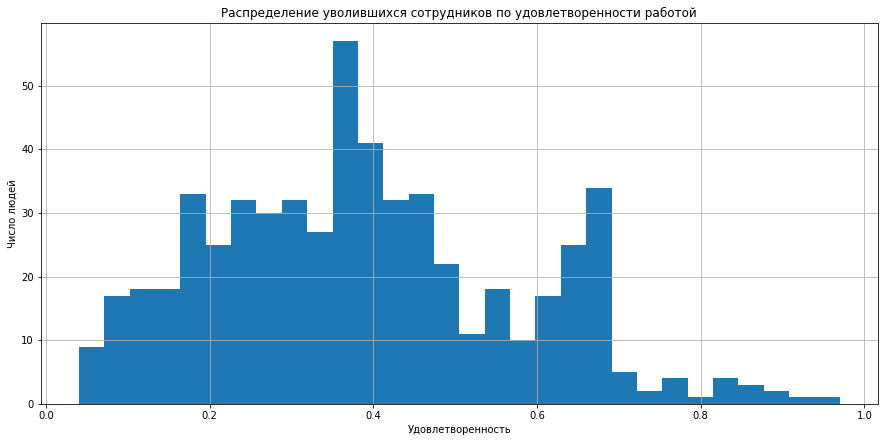

In [68]:
full_data[full_data['quit']=='yes']['job_satisfaction_rate'].hist(figsize=(15, 7), bins=30)
plt.xlabel('Удовлетворенность')
plt.ylabel('Число людей')
plt.title('Распределение уволившихся сотрудников по удовлетворенности работой')
plt.show()

У сотрудников, уволившихся с компании пик распределения приходится на удовлетворенность близ 0.3

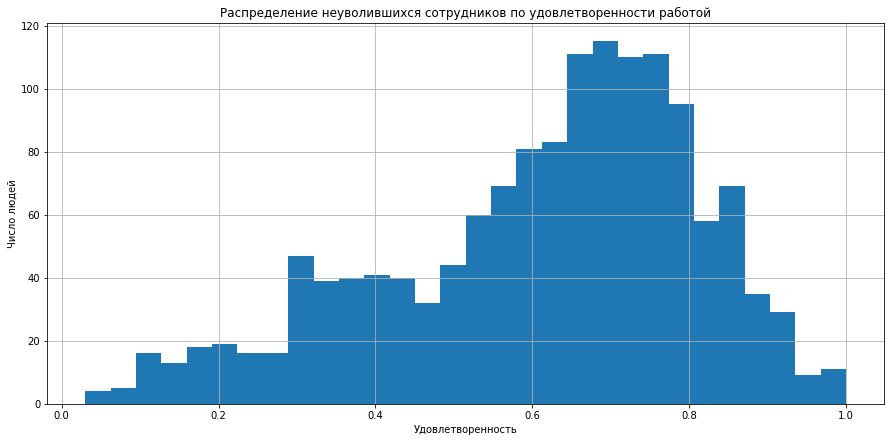

In [69]:
full_data[full_data['quit']=='no']['job_satisfaction_rate'].hist(figsize=(15, 7), bins=30)
plt.xlabel('Удовлетворенность')
plt.ylabel('Число людей')
plt.title('Распределение неуволившихся сотрудников по удовлетворенности работой')
plt.show()

Обратную ситуацию можем наблюдать у сотрудников, которые не уволились с компании. Их оценка удовлетворенности в среднем гораздо больше и пик приходится на 0.7. Отсюда делаем вывод, что действительно есть связь между увольнением и оценкой удовлетворенности

На этом этапе мы провели исследовательский анализ данных датасета и составили портрет уволившегося сотрудника. Так же мы убедились в наличии связи между удовлетворенностью работой и увольнением

## Шаг 4. Добавление нового входного признака

В предыдущем пункте мы обнаружили необходимую связь, поэтому добавим признак удовлетворенности в датасет, используя обученную модель из предыдущей задачи

In [70]:
best_model = random_search.best_estimator_.named_steps['models']
preprocessor = random_search.best_estimator_.named_steps['preprocessor']
X_train_preprocessed = preprocessor.transform(train_quit.drop(columns=['id', 'quit'], axis=1))

In [71]:
train_quit['job_satisfaction_rate'] = best_model.predict(X_train_preprocessed)
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.646855
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.833371
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.380065
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.296026
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.738520


Делаем аналогичные действия для входных признаков в тестовой выборке

In [72]:
X_test_preprocessed = preprocessor.transform(test_features.drop(columns=['id'], axis=1))
test_features['job_satisfaction_rate'] = best_model.predict(X_test_preprocessed)
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.800366
1,686555,hr,junior,medium,1,no,no,4,30000,0.657785
2,467458,sales,middle,low,5,no,no,4,19200,0.655794
3,418655,sales,middle,low,6,no,no,4,19200,0.654034
4,789145,hr,middle,medium,5,no,no,5,40800,0.807146


Теперь можно переходить к подготовке данных

## Шаг 5. Подготовка данных

Для начала построим матрицу корреляций 

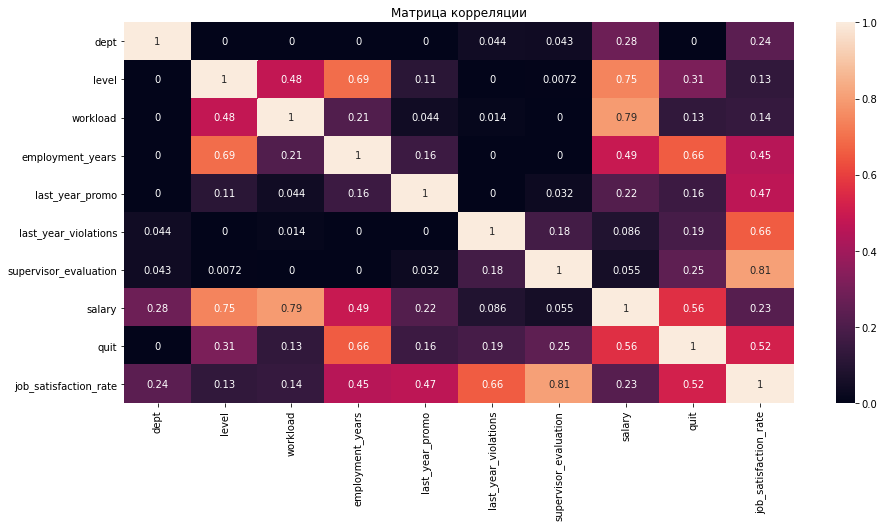

In [73]:
interval_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

phik_corr = train_quit.drop(['id'], axis=1).phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(15, 7))
sns.heatmap(phik_corr, annot=True)
plt.title('Матрица корреляции')
plt.show()

Мультиколлинераность так же не обнаружена. Перейдем к построению пайплайна, оно выглядит так же, как и в прошлой задаче

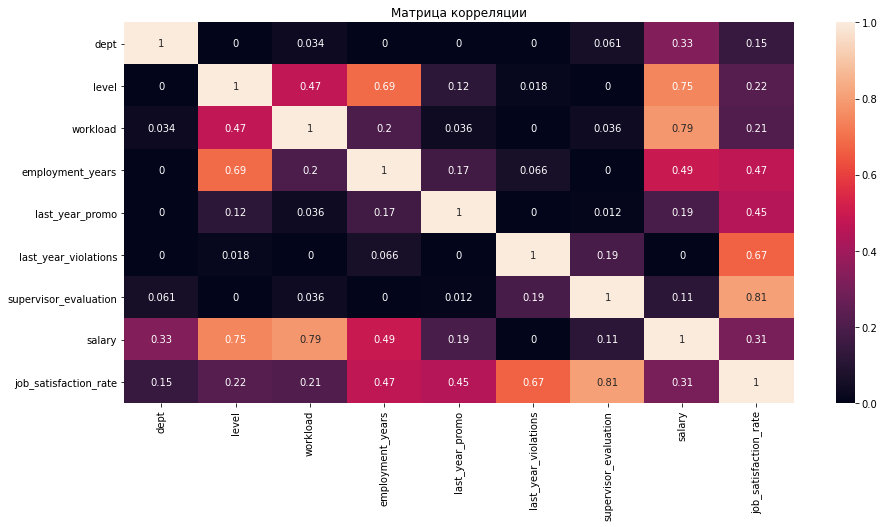

In [74]:
phik_corr = test_features.drop(['id'], axis=1).phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(15, 7))
sns.heatmap(phik_corr, annot=True)
plt.title('Матрица корреляции')
plt.show()

Проведем анализ нового признака в тестовых признаках

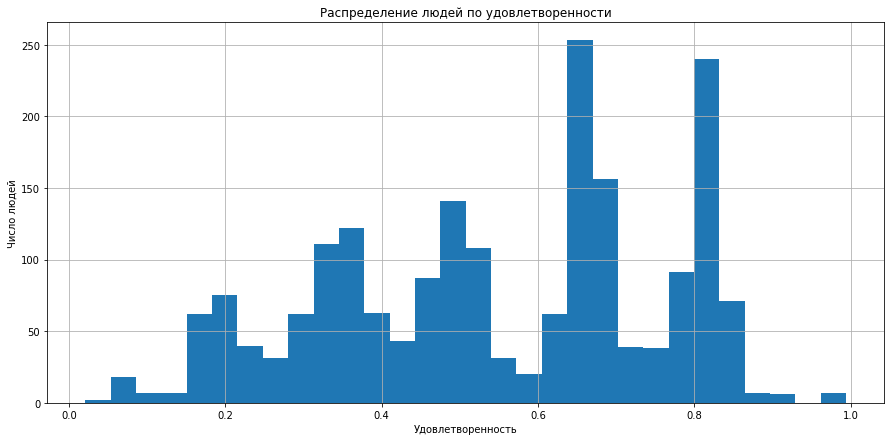

In [75]:
test_features['job_satisfaction_rate'].hist(figsize=(15, 7), bins=30)
plt.xlabel('Удовлетворенность')
plt.ylabel('Число людей')
plt.title('Распределение людей по удовлетворенности')
plt.show()

Видим, что имеется несколько пиков. Это связано с тем, что новый столбец добавлялся на основе данных, полученных от обученной модели

In [76]:
X_train = train_quit.drop(['id', 'quit'], axis=1)
y_train = train_quit['quit']
RANDOM_STATE = 42

Кодируем целевой признак

In [77]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [78]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

ord_columns = ['level', 'workload']

num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [79]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[['junior', 'middle', 'sinior'],
                                       ['low', 'medium', 'high']], handle_unknown='use_encoded_value', unknown_value=np.nan)
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

Теперь создадим словари для всех моделей

In [80]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # слоаврь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Пайплайн окончательно подготовим, на следующем шаге обучим модель 

## Шаг 6. Обучение модели

In [81]:
random_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [82]:
print ('Метрика лучшей модели при кросс-валидации:', random_search.best_score_)
print('Лучшие параметры:', random_search.best_params_)

Метрика лучшей модели при кросс-валидации: 0.9284283832122935
Лучшие параметры: {'preprocessor__num': StandardScaler(), 'models__C': 4, 'models': SVC(probability=True, random_state=42)}


Проверим, как показывает себя метрика roc-auc на тестовой выборке

In [83]:
test_full = test_features.merge(test_target_quit, on='id')
X_test = test_full.drop(['id', 'quit'], axis=1)
y_test = test_full['quit']
y_pred_test = random_search.predict_proba(X_test)[:,1]
y_test_encoded = le.transform(y_test)

roc_auc = roc_auc_score(y_test, y_pred_test)
print(f'ROC-AUC: {roc_auc}')

ROC-AUC: 0.9252411396906299


На тестовой выборке метрика roc-auc показала 0.925, что можно считать успешным результатом при пороге 0.91

## Шаг 7. Выводы

На предыдущем шаге мы обучили 4 модели классификации и лучше всего себя показала модель SVC c С = 4. Выбор модели происходил посредством перебора гиперпараметров, для SVC модели был указан список для гиперпараметра C

## Общий вывод

В данном проекте предстояло решить 2 задачи: задачу регресии и классификации

**Задача 1** 

Эта задача состояла в том, чтобы определить степень удовлетворенности сотрудников в компании. Для этого в самом начале мы загрузили тестовые и тренировочные данные, затем выполнили предобработку данных в них. Далее был проведен исследовательский анализ данных и корреляционный анализ данных

Мултьиколлинеарности выявлено не было, поэтому мы перешли к подготовке пайплайна. В пайплайне было использовано 3 модели с подбором гиперпараметров. Победил градиентный бустинг со следующими параметрами: {'preprocessor__num': 'passthrough', 'models__n_estimators': 150, 'models__min_samples_leaf': 2, 'models__max_depth': 4, 'models__learning_rate': 0.1, 'models': GradientBoostingRegressor(max_depth=4, min_samples_leaf=2, n_estimators=150)}

Модель показала хорошую метрику SMAPE на тестовых данных 11.67

**Задача 2**

Эта задача состояла в том, чтобы предсказать увольнение сотрудника. Как и в прошлой задаче мы провели предобработку данных и исследовательский анализ данных

В процессе обучения было использовано 4 модели, среди которых победила SVC c С = 4

В качестве основной метрики была использована метрика ROC-AUC, которая показала хороший результат в 0.925 на тестовых данных

**Рекомендации для бизнеса**

Тщательное исследование данных показало, что чаще всего увольнялись сотрудники с низкой удовлетворенностью. На удовлетворенность влияют заработная плата и загруженность. Опираясь на портрет уволившегося сотрудника можно сказать, что сотруднику необходимо давать большой объем работы с достойной оплатой, в таком случае повысится удовлетворенность и соответсвенно увольнений будет меньше